In [1]:
import numpy as np 
import pandas as pd
import os
from Dataset.Utils import prepare_data_range, read_fasta
from Dataset.Resample import resample

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
embeds_paths = "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_embeds.npy"
ids_paths = "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_ids.npy"

In [3]:
print("Loading training embeddings...")
train_embeds = np.load(embeds_paths)
train_embeds_ids = np.load(ids_paths)

Loading training embeddings...


In [7]:
BASE_PATH = "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/"
train_terms_df = pd.read_csv(os.path.join(BASE_PATH, 'Train/train_terms.tsv'), sep='\t')
print(f"Training terms loaded. Shape: {train_terms_df.shape}")
train_fasta_path = os.path.join(BASE_PATH, 'Train/train_sequences.fasta')
train_sequences = read_fasta(train_fasta_path)

Training terms loaded. Shape: (537027, 3)
[io] Read 82404 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_sequences.fasta


In [5]:
train_ids = np.array(list(train_sequences.keys()))

In [6]:
train_terms_df.groupby('EntryID').agg(terms= ('term', 'count')).sort_values('terms')

,terms
EntryID,
A0A023G6B6,1
A0A023FT45,1
A0A023FFB5,1
W7LUF3,1
W7LL82,1
...,...
P31749,151
P05067,155
Q01705,175


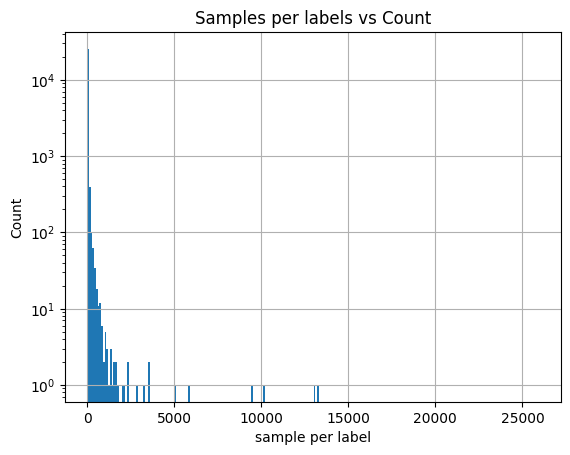

In [15]:
label_freq = train_terms_df.groupby('term').agg(entries= ('EntryID', 'count')).sort_values('entries', ascending=False)

bins = np.arange(0, 26000, 100)

plt.hist(label_freq['entries'], bins=bins)
plt.yscale('log') 
plt.title('Samples per labels vs Count')
plt.xlabel('sample per label')
plt.ylabel('Count')
# plt.xlim((0,1000))
plt.grid(True)
plt.show()

In [20]:
label_freq['pos_ratio'] = label_freq['entries'] / len(train_ids)
label_freq

,entries,pos_ratio
term,,
GO:0005515,33713,0.409118
GO:0005634,13283,0.161194
GO:0005829,13040,0.158245
GO:0005886,10150,0.123174
GO:0005737,9442,0.114582
...,...,...
GO:2001291,1,0.000012
GO:2001286,1,0.000012
GO:2001279,1,0.000012


In [21]:
label_freq.describe()

,entries,pos_ratio
count,26125.000000,26125.000000
mean,20.556057,0.000249
std,268.143836,0.003254
min,1.000000,0.000012
25%,2.000000,0.000024
50%,4.000000,0.000049
75%,12.000000,0.000146
max,33713.000000,0.409118


In [13]:
data = prepare_data_range(train_terms_df, train_ids, train_embeds, top_range=[64, 80])
data['labels'].shape

(8215, 16)

Text(0, 0.5, 'Positive ratio')

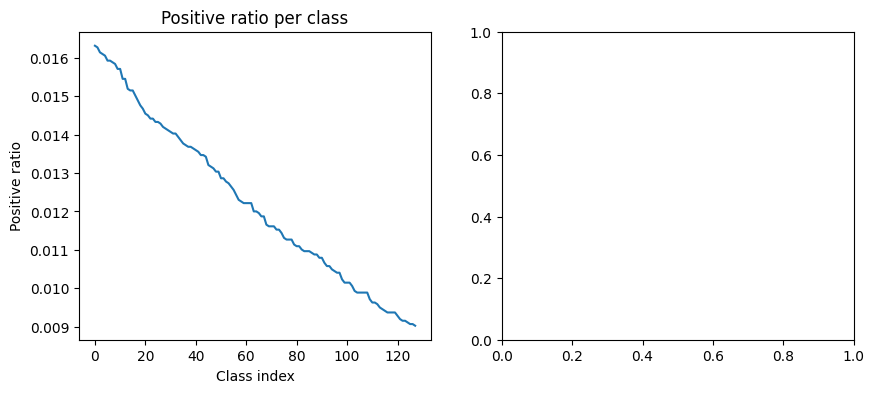

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

pos_ratio = data['labels'].sum(axis=0) / data['labels'].shape[0]

ax[0].plot(pos_ratio)
ax[0].set_title('Positive ratio per class')
ax[0].set_xlabel('Class index')
ax[0].set_ylabel('Positive ratio')

In [ ]:
from diamondonpy import Diamond
from pathlib import Path

diamond = Diamond()

db_path = Path("/mnt/d/ML/Kaggle/CAFA6-new/uniprot/uniprot_sprot.dmnd")
query_path = Path("/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/train/train_sequences.fasta") 

results_df = diamond.blastp(
    db=str(db_path),    
    query=str(query_path),
    outfmt="6 qseqid sseqid pident evalue bitscore qcovhsp",
    evalue=1e-3,
    max_target_seqs=500,
)


In [7]:

print(results_df.shape)
results_df.head()

(6599605, 6)


,qseqid,sseqid,pident,evalue,bitscore,qcovhsp
0,sp|A0A0C5B5G6|MOTSC_HUMAN,sp|A0A0C5B5G6|MOTSC_HUMAN,100.0,7.220000e-06,38.9,100
1,sp|A0JNW5|BLT3B_HUMAN,sp|A0JNW5|BLT3B_HUMAN,100.0,0.000000e+00,2818.0,100
2,sp|A0JNW5|BLT3B_HUMAN,sp|A2RSJ4|BLT3B_MOUSE,83.6,0.000000e+00,2352.0,99.8
3,sp|A0JNW5|BLT3B_HUMAN,sp|Q6NRZ1|BLT3B_XENLA,59.2,0.000000e+00,1578.0,100
4,sp|A0JNW5|BLT3B_HUMAN,sp|Q6BDS2|BLT3A_HUMAN,40.9,3.310000e-312,925.0,99.7


In [10]:
# Extract IDs from pipe-delimited format (e.g., sp|P12345|PROT_HUMAN -> P12345)
results_df['qseqid'] = results_df['qseqid'].str.split('|').str[1]
results_df['sseqid'] = results_df['sseqid'].str.split('|').str[1]

print(results_df.shape)
results_df.head()

(6517482, 6)


,qseqid,sseqid,pident,evalue,bitscore,qcovhsp
2,A0JNW5,A2RSJ4,83.6,0.000000e+00,2352.0,99.8
3,A0JNW5,Q6NRZ1,59.2,0.000000e+00,1578.0,100
4,A0JNW5,Q6BDS2,40.9,3.310000e-312,925.0,99.7
6,A0JP26,H3BUK9,92.4,6.530000e-204,583.0,100
7,A0JP26,A0A0A6YYL3,92.4,6.530000e-204,583.0,100


In [ ]:
results_df[['evalue', 'bitscore']].describe()


,evalue,bitscore
count,6.517482e+06,6.517482e+06
mean,4.933894e-06,2.339771e+02
std,4.900285e-05,2.431647e+02
min,0.000000e+00,3.350000e+01
25%,1.300000e-85,1.000000e+02
50%,1.550000e-45,1.660000e+02
75%,1.240000e-22,2.730000e+02
max,1.000000e-03,5.926400e+04


: 

In [8]:
results_df.drop(results_df[results_df['qseqid'] == results_df['sseqid']].index, inplace=True   )
results_df.shape

(6517482, 6)

In [9]:
results_df.groupby('qseqid').agg(num_hits=('sseqid', 'count')).describe()

,num_hits
count,77035.000000
mean,84.604167
std,133.712480
min,1.000000
25%,7.000000
50%,24.000000
75%,87.000000
max,499.000000
